# Import library

In [1]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Some useful function

In [3]:
def plot_result(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted',color='red', linestyle='dashed')
    plt.title('Actual vs Predicted')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
def minute_into_day(df: pd.DataFrame) -> pd.DataFrame:
    COLS_NAME = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    interval = df['Date'].drop_duplicates().to_list()

    new_df = []

    for date in interval:        
        rows = df[(df['Date'] == date)]
        
        max_high = rows['High'].max()
        min_low = rows['Low'].min()

        first_open = rows.iat[0,2]
        last_close = rows.iat[len(rows)-1,5]

        sum_volume = rows['Volume'].sum()

        new_df.append([date, first_open, max_high, min_low, last_close, sum_volume])

    return pd.DataFrame(new_df, columns=COLS_NAME)

In [5]:
def minute_into_month(df: pd.DataFrame) -> pd.DataFrame:
    COLS_NAME = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df= df.drop_duplicates(subset=['Date'])

    new_df = []
    for date in df['Date']:
        rows = df[(df['Date'] == date)]
        
        max_high = rows['High'].max()
        min_low = rows['Low'].min()

        first_open = rows.iat[0,2]
        last_close = rows.iat[len(rows)-1,5]

        sum_volume = rows['Volume'].sum()

        new_df.append([date, first_open, max_high, min_low, last_close, sum_volume])
    return pd.DataFrame(new_df, columns=COLS_NAME)

In [6]:
def caculate_price_fluctuations(df: pd.DataFrame):
    change = [0]

    for i in range(0,len(df)-1):
        change.append(df.iat[i+1,4]-df.iat[i,4])

    df['Change'] = change

In [7]:
def measure_metric(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    print('Mean Square Error: {}'.format(mse))
    print('Root Mean Square Error: {}'.format(rmse))
    print('Mean Absolute Error: {}'.format(mae))
    
    return mse, rmse, mae

# Data Loading

In [8]:
fpt = pd.read_csv('data/FPT.csv')
msn = pd.read_csv('data/MSN.csv')
pnj = pd.read_csv('data/PNJ.csv')
vic = pd.read_csv('data/VIC.csv')
data = {'fpt':fpt,
        'msn':msn,
        'pnj':pnj,
        'vic':vic}

# 1. Preprocessing:

## Split Date/Time into Date and Time

In [9]:
for i in data.keys():
    data[i]['Date'] = data[i]['Date/Time'].apply(lambda x: x.split()[0])
    data[i]['Time'] = data[i]['Date/Time'].apply(lambda x: x.split()[1])
    data[i]['Time'] = pd.to_datetime(data[i]['Time'], format='%H:%M')
    data[i]['Time'] = data[i]['Time'].dt.hour
    data[i] = data[i][['Ticker','Date','Time','Open','High','Low','Close','Volume','Open Interest']]

## Drop unnecessary columns

In [10]:
for i in data.keys():
    data[i] = data[i].drop(['Ticker','Open Interest'],axis=1)

## Convert minutes into days

While converting the dataset from minutes to hours, I'm also dropping duplicate columns

In [11]:
for i in data.keys():
    data[i] = minute_into_day(data[i])

## Caculate price fluctuations

In [12]:
for i in data.keys():
    caculate_price_fluctuations(data[i])

***NOTE**: The first row of the dataset will not have data due to the lack of data from the previous day.*

## **Describe dataset**

In [13]:
data['fpt'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    499 non-null    object 
 1   Open    499 non-null    float64
 2   High    499 non-null    float64
 3   Low     499 non-null    float64
 4   Close   499 non-null    float64
 5   Volume  499 non-null    int64  
 6   Change  499 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 27.4+ KB


#### **There are some comments on FPT's dataset**
*The data has been condensed from approximately 100,000 rows down to 499 rows,*

*There are no null values in the dataset,*

*Based on the results, the data spans from 25/12/2018 to 22/12/2020 indicating a substantial timeframe for the recorded data..*

In [14]:
for i in data.keys():
    print('Stock name:',i)
    display(data[i]['Change'].describe())

Stock name: fpt


count    499.00000
mean       0.05499
std        0.71014
min       -3.15000
25%       -0.29000
50%        0.08000
75%        0.40000
max        2.91000
Name: Change, dtype: float64

Stock name: msn


count    748.000000
mean       0.011497
std        1.664416
min       -7.000000
25%       -0.800000
50%        0.000000
75%        0.800000
max        7.100000
Name: Change, dtype: float64

Stock name: pnj


count    709.000000
mean      -0.000578
std        1.652976
min       -6.730000
25%       -0.880000
50%        0.000000
75%        0.900000
max        5.630000
Name: Change, dtype: float64

Stock name: vic


count    548.000000
mean       0.012226
std        1.633789
min       -7.300000
25%       -0.500000
50%        0.000000
75%        0.500000
max        6.300000
Name: Change, dtype: float64

*The maximum value of price fluctuation significantly exceeds the average fluctuation,* 

*suggesting that market prices could spike abruptly, possibly due to significant news, etc.*

# 2. Exploratory Data Analysis:

## Initializing a Return Series and Surveying Data

In [15]:
r_t = np.log(data['fpt']['Close']/data['fpt']['Close'].shift(1)).values

mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

array([ 0.00128355,  0.00747363,  0.00966502,  0.0095725 , -0.0241053 ])

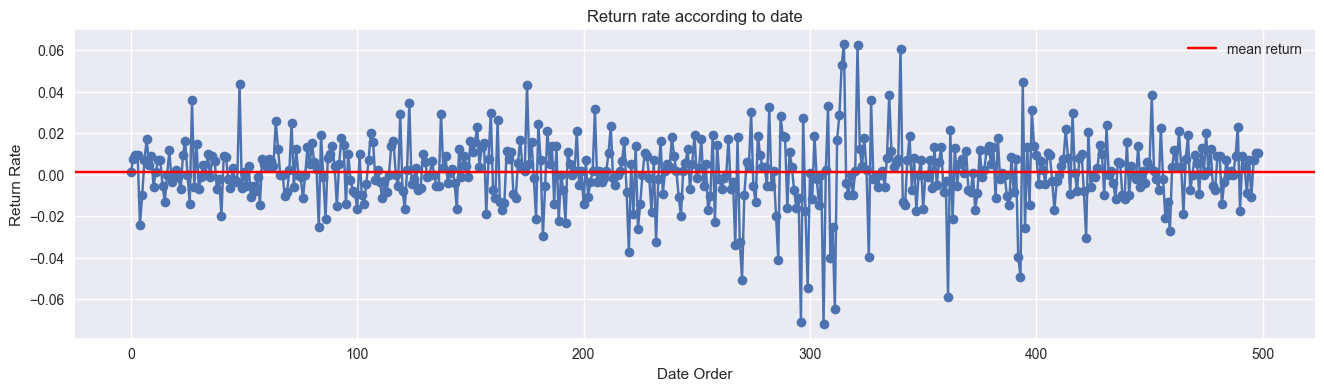

In [16]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(r_t.shape[0]), r_t, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

***NOTE**: The return series chart shows that it is a random walk resembling white noise, with a mean close to zero and constant variance.*

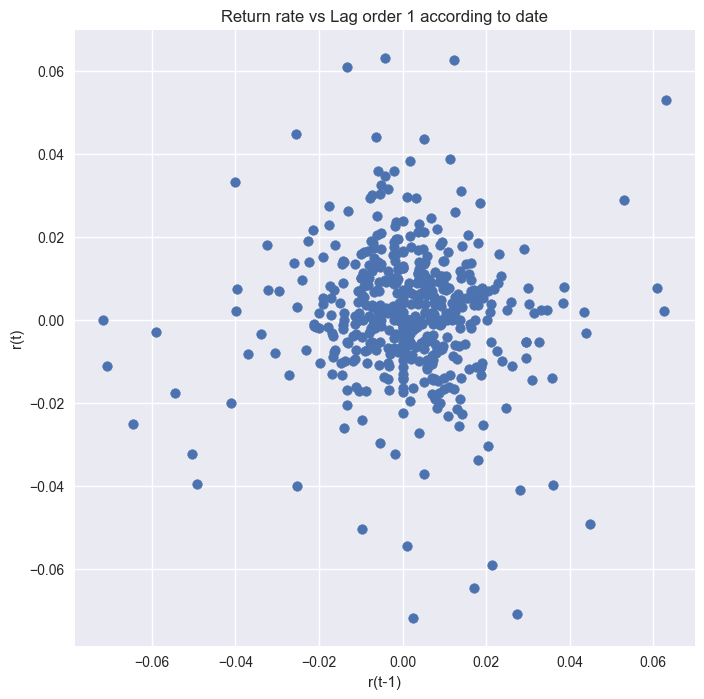

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

*The plot shows that the two series r(t) and r(t-1) have no correlation.*

*Their plot is a collection of points that do not follow any specific trend.*

## Line plot

In [18]:
df_month = fpt.copy()

df_month['Date'] = df_month['Date/Time'].apply(lambda x: x.split()[0])
df_month['Date'] =  pd.to_datetime(df_month['Date'], format='%m/%d/%Y').dt.strftime('%m/%Y')
df_month = df_month[['Ticker','Date','Open','High','Low','Close','Volume','Open Interest']]
df_month = df_month.drop(['Ticker','Open Interest'],axis=1)
df_month = minute_into_month(df_month)
caculate_price_fluctuations(df_month)

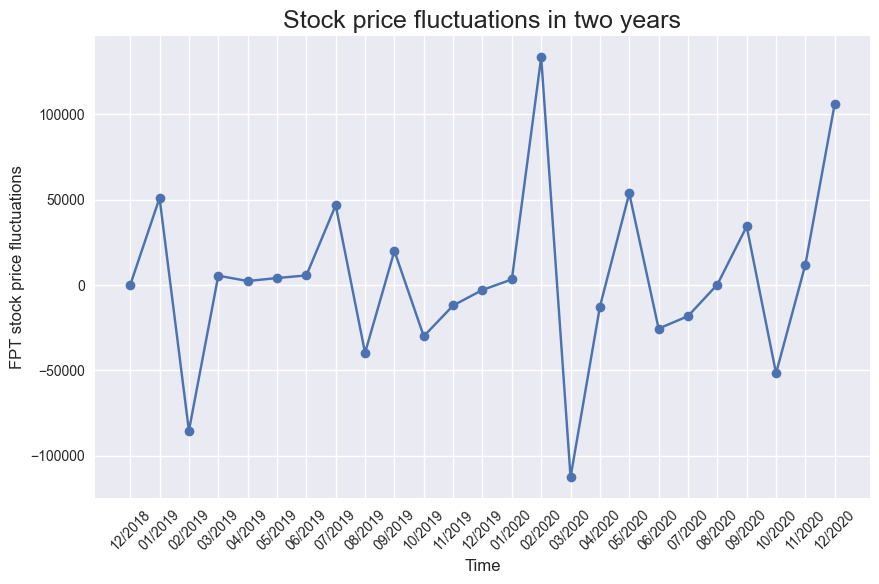

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df_month['Date'],df_month["Change"], marker="o")
plt.xticks(rotation=45)
plt.xlabel("Time", fontsize=12)
plt.ylabel("FPT stock price fluctuations", fontsize=12)
plt.title("Stock price fluctuations in two years", fontsize=18)
plt.show()

## Box plot 

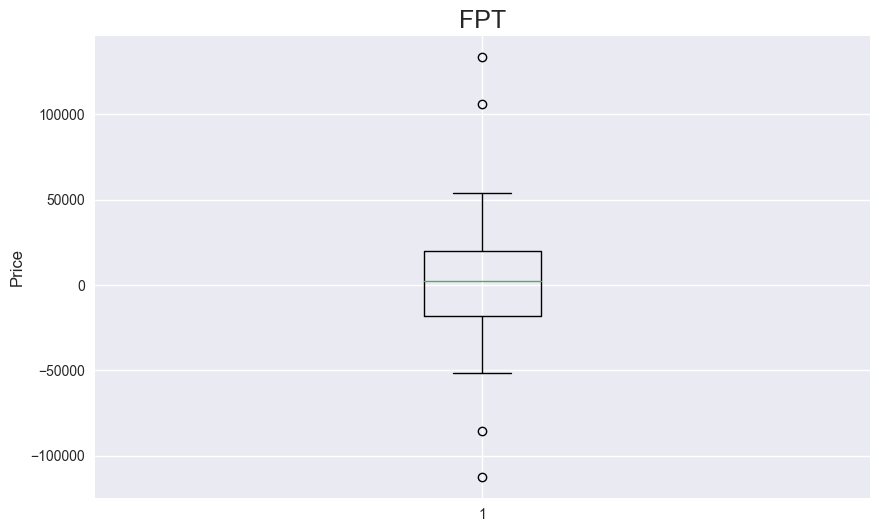

In [20]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_month['Change'])
plt.ylabel("Price", fontsize=12)
plt.title("FPT", fontsize=18)
plt.show()

In [21]:

def detect_outliers(series):
  """
    series: 1-D numpy array input
  """
  Q1 = np.quantile(series, 0.25)
  Q3 = np.quantile(series, 0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  lower_compare = series <= lower_bound
  upper_compare = series >= upper_bound
  outlier_idxs = np.where(lower_compare | upper_compare)[0]
  return outlier_idxs

outlier_idxs=detect_outliers(df_month['Change'])
print("Outlier indices: ", outlier_idxs)
print("Outlier months: ", df_month['Date'][outlier_idxs])
print("Outlier values: ", df_month['Change'][outlier_idxs].values)

Outlier indices:  [ 2 14 15 24]
Outlier months:  2     02/2019
14    02/2020
15    03/2020
24    12/2020
Name: Date, dtype: object
Outlier values:  [ -85400  133480 -112590  106260]


*Thus, from the box-plot and line-plot, we can conclude that the period from 02/2019 to 12/2020 was affected by the COVID-19 pandemic,*

*leading to significant volatility in the stock market.*

### Check for stationarity

In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -22.805085
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


*The p-value is less than 0.05, so we reject the null hypothesis H0.*

*The characteristic equation has no unit root. Therefore, the return series is stationary.*

In [23]:
# Sort features by absolute autocorrelation value
autocorr_features = data['fpt'].drop(['Date','Change'], axis=1).apply(lambda x: x.autocorr())
autocorr_features = autocorr_features.abs().sort_values(ascending=False)
print(autocorr_features)

High      0.995446
Low       0.995019
Close     0.994431
Open      0.993017
Volume    0.446453
dtype: float64


***Selecting values with high correlation***

# 3. Building Model:

### Moving average

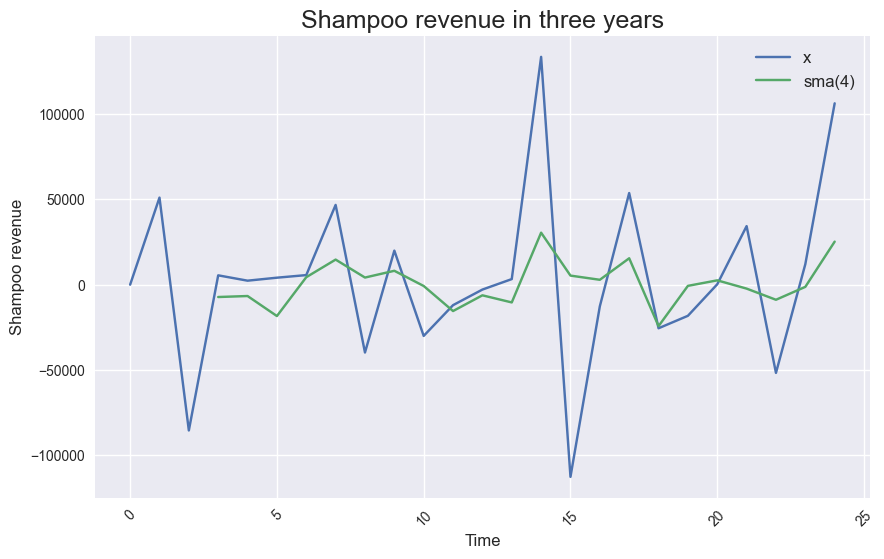

In [24]:
# Single moving average in pandas'
df = df_month.copy()
df_sma = df.rolling(window=4).mean()
plt.figure(figsize=(10, 6))
plt.plot(df["Change"], label="x")
plt.plot(df_sma["Change"], label="sma(4)")
plt.xticks(rotation=45)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Shampoo revenue", fontsize=12)
plt.legend(fontsize=12)
plt.title("Shampoo revenue in three years", fontsize=18)
plt.show()

***Train\Test splitting***

In [25]:
df = data['fpt'].copy()
index = int(len(df)*0.8)

data_train = df[:index]
data_test = df[index:]

scaler = StandardScaler()
data_train_scale  = scaler.fit_transform(data_train[['Open', 'High', 'Low', 'Change']])
data_test_scale = scaler.fit_transform(data_test[['Open', 'High', 'Low', 'Change']])

X_train, y_train = data_train_scale[:,0:3], data_train_scale[:,-1]
X_test, y_test = data_test_scale[:,0:3], data_test_scale[:,-1]


## 1. Arima model:

<Figure size 800x600 with 0 Axes>

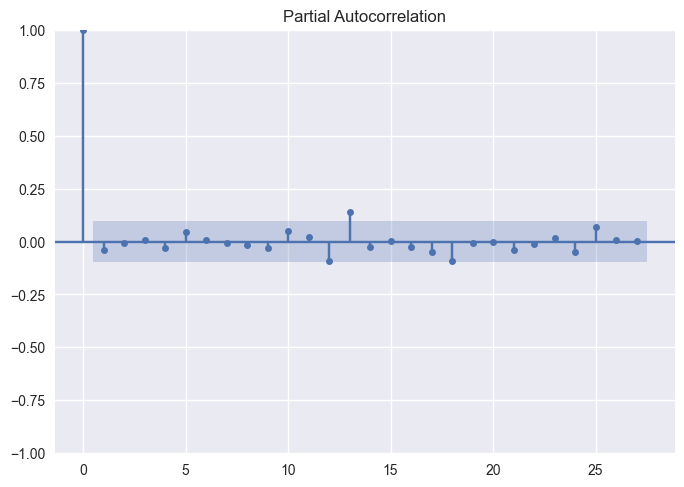

In [26]:
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(y_train)

In [27]:
model = auto_arima(y_train,
           seasonal=False,
           trace=True 
        )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1141.633, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1134.313, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1135.659, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1135.649, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1137.636, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1136.313, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.138 seconds


***Choose the best AIC and BIC score for Arima model***

In [28]:
n_periods = len(y_test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

measure_metric(y_test, forecast)

Mean Square Error: 1.0
Root Mean Square Error: 1.0
Mean Absolute Error: 0.7704591752635462


(1.0, 1.0, 0.7704591752635462)

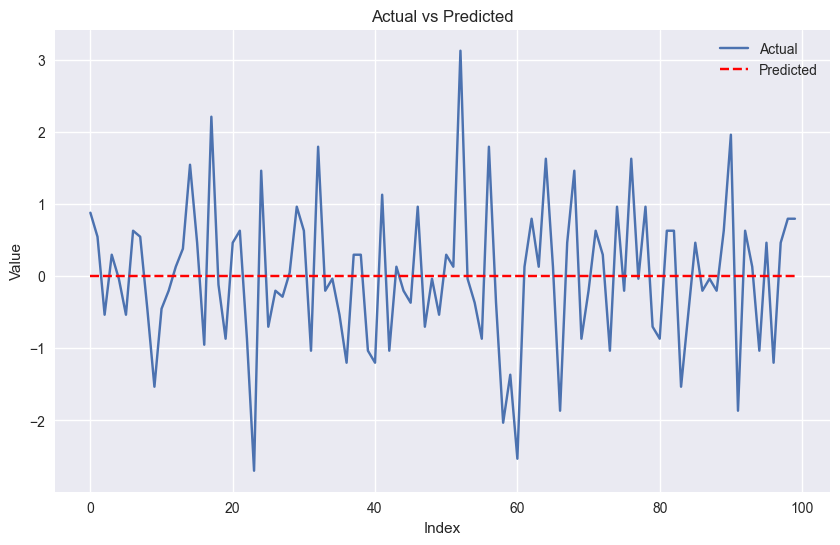

In [29]:
plot_result(y_test,forecast)

## 2. SVR

In [30]:
svr_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]  # Chỉ sử dụng khi kernel='poly'
}
grid_search = GridSearchCV(SVR(), svr_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'C': 100, 'degree': 2, 'epsilon': 0.1, 'kernel': 'linear'}


In [31]:
svr_model = grid_search.best_estimator_
forecast = svr_model.predict(X_test[:,0:3])
measure_metric(y_test, forecast)

Mean Square Error: 0.8847164663835057
Root Mean Square Error: 0.9405936776225459
Mean Absolute Error: 0.7421427490442732


(0.8847164663835057, 0.9405936776225459, 0.7421427490442732)

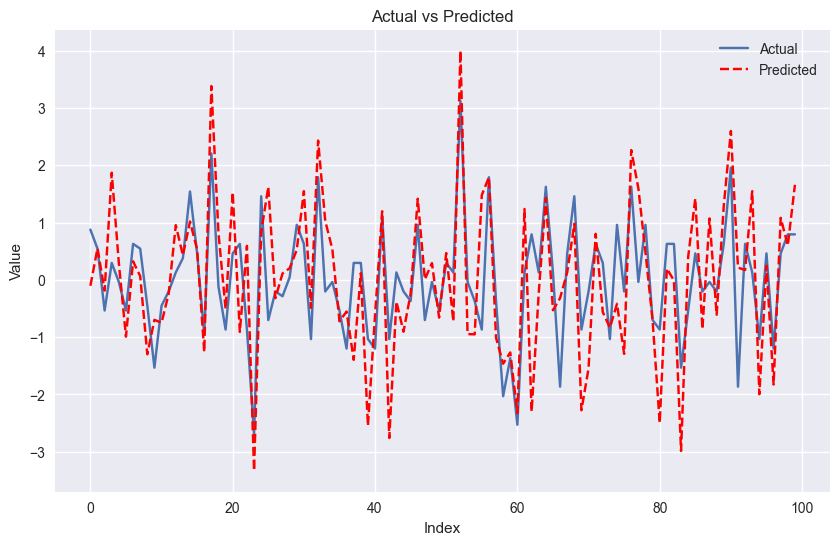

In [32]:
plot_result(y_test,forecast)

## 3. XGRegressor:

In [33]:
xg_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(XGBRegressor(), xg_params, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)

[06:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__subsample" } are not used.

[06:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__subsample" } are not used.

[06:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__subsample" } are not used.

[06:46:59] WARNING: C:\buildkite-agent\b

In [34]:
xg_model = grid_search.best_estimator_
forecast = xg_model.predict(X_test[:,0:3])
measure_metric(y_test, forecast)

Mean Square Error: 0.7924136613135725
Root Mean Square Error: 0.8901761967799254
Mean Absolute Error: 0.6875607429308266


(0.7924136613135725, 0.8901761967799254, 0.6875607429308266)

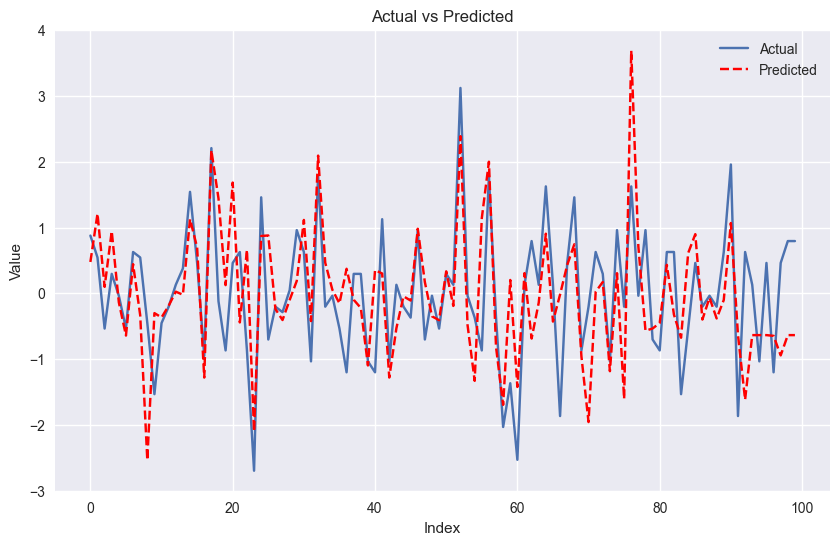

In [35]:
plot_result(y_test,forecast)

## 4. LSTM

In [36]:
X_train_tensor = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [37]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train_tensor.shape[1], X_train_tensor.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [38]:
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 60)          │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 80)          │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=200, batch_size = 64, verbose=0)

In [40]:
y_pred = regressor.predict(X_test)
measure_metric(y_test, y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
Mean Square Error: 1.0493609987557082
Root Mean Square Error: 1.0243832284627215
Mean Absolute Error: 0.7939116113275921


(1.0493609987557082, 1.0243832284627215, 0.7939116113275921)

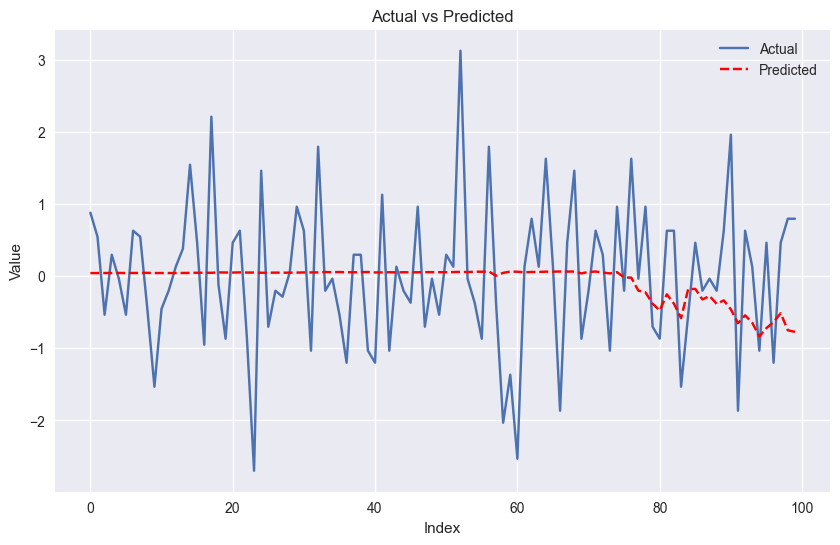

In [41]:
plot_result(y_test,y_pred)

# 4. Building Pipeline:

***Based on the models above, it can be seen that the pandemic significantly affects time series forecasting models. Its impact can alter conventional economic factors, potentially leading to overfitting of the data in the models.***

***Building processing pipeline***

In [42]:
class MovingAverage(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df_sma = X.rolling(window=4).mean()
        return df_sma
    
class Imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_interpolated = X.interpolate(method='linear', axis=0).ffill().bfill()
        return X_interpolated


In [43]:
process_pipeline = Pipeline([
        ('Moving Average',MovingAverage()),
        ('Imputer',Imputer()), # Impute missing value
        ('Standard Scaler', StandardScaler())])
process_pipeline 

Pipeline(steps=[('Moving Average', MovingAverage()), ('Imputer', Imputer()),
                ('Standard Scaler', StandardScaler())])

In [44]:
class LSTMRegressor:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.regressor = self.build_model()

    def build_model(self):
        regressor = Sequential()

        regressor.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=self.input_shape))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units=60, activation='relu', return_sequences=True))
        regressor.add(Dropout(0.3))

        regressor.add(LSTM(units=80, activation='relu', return_sequences=True))
        regressor.add(Dropout(0.4))

        regressor.add(LSTM(units=120, activation='relu'))
        regressor.add(Dropout(0.5))

        regressor.add(Dense(units=1))

        return regressor

    def compile_model(self, optimizer='adam', loss='mse'):
        self.regressor.compile(optimizer=optimizer, loss=loss)

    def train(self, X_train, y_train, epochs=200, batch_size=64):
        history = self.regressor.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose=0)
        return history

    def predict(self, X):
        return self.regressor.predict(X)

# 5. Applying for all stocks:

## FPT

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Mean Square Error: 0.009749688528480984
Root Mean Square Error: 0.09874051108071592
Mean Absolute Error: 0.0717891360228099


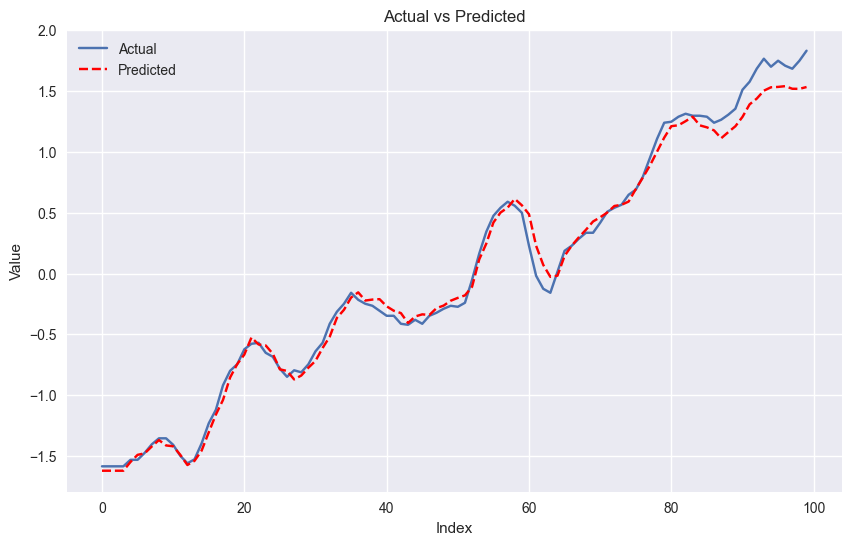

In [45]:
def result(data):
    df = data.copy()
    index = int(len(df)*0.8)

    data_train = df[:index]
    data_test = df[index:]

    X_train, y_train = data_train[['Open', 'High', 'Low', 'Close']], data_train[['Change']]
    X_test, y_test = data_test[['Open', 'High', 'Low', 'Close']], data_test[['Change']]

    data_train_scale = process_pipeline.fit_transform(X_train, y_train)
    data_test_scale =  process_pipeline.fit_transform(X_test, y_test)

    X_train, y_train = data_train_scale[:,0:3], data_train_scale[:,-1]
    X_test, y_test = data_test_scale [:,0:3], data_test_scale[:,-1]

    X_train_tensor = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    input_shape = (X_train_tensor.shape[1], X_train_tensor.shape[2])
    lstm_regressor = LSTMRegressor(input_shape)

    # Compile the model
    lstm_regressor.compile_model()

    # Train the model
    history = lstm_regressor.train(X_train, y_train)

    # Predict using the trained model
    predictions = lstm_regressor.predict(X_test)
    
    return y_test, predictions, index
y_test, predictions, index = result(data['fpt'])
measure_metric(y_test, predictions)
plot_result(y_test,predictions)

## MSN

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/stepWARNING:tensorflow:6 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000027D0D04C430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Mean Square Error: 0.009468719739494548
Root Mean Square Error: 0.09730734679095175
Mean Absolute Error: 0.08415072603700174


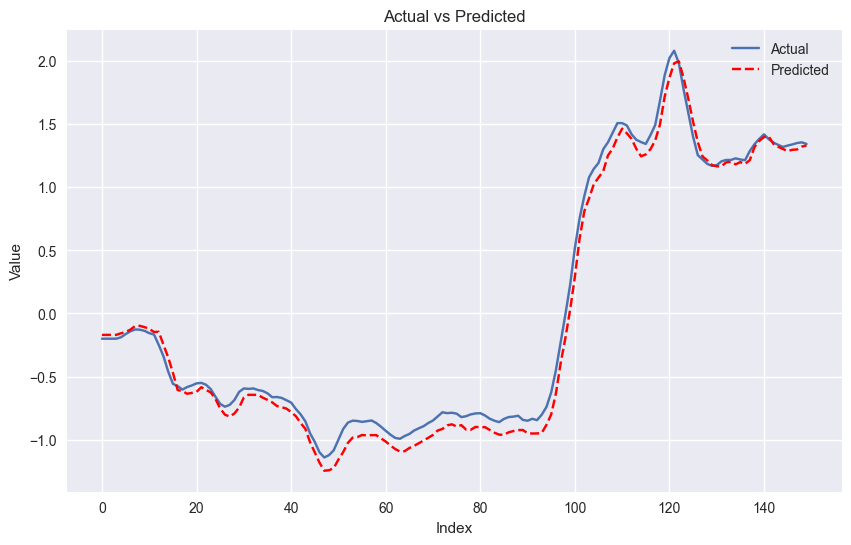

In [46]:
def result(data):
    df = data.copy()
    index = int(len(df)*0.8)

    data_train = df[:index]
    data_test = df[index:]

    X_train, y_train = data_train[['Open', 'High', 'Low', 'Close']], data_train[['Change']]
    X_test, y_test = data_test[['Open', 'High', 'Low', 'Close']], data_test[['Change']]

    data_train_scale = process_pipeline.fit_transform(X_train, y_train)
    data_test_scale =  process_pipeline.fit_transform(X_test, y_test)

    X_train, y_train = data_train_scale[:,0:3], data_train_scale[:,-1]
    X_test, y_test = data_test_scale [:,0:3], data_test_scale[:,-1]

    X_train_tensor = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    input_shape = (X_train_tensor.shape[1], X_train_tensor.shape[2])
    lstm_regressor = LSTMRegressor(input_shape)

    # Compile the model
    lstm_regressor.compile_model()

    # Train the model
    history = lstm_regressor.train(X_train, y_train)

    # Predict using the trained model
    predictions = lstm_regressor.predict(X_test)
    
    return y_test, predictions, index
y_test, predictions, index = result(data['msn'])
measure_metric(y_test, predictions)
plot_result(y_test,predictions)

## PNJ

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Mean Square Error: 0.005367416046132287
Root Mean Square Error: 0.07326265109953561
Mean Absolute Error: 0.058747722611229396


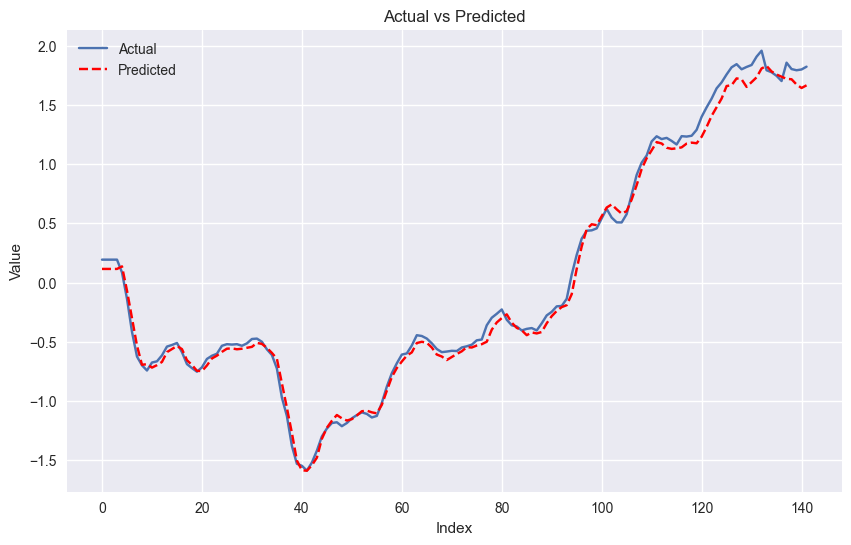

In [47]:
def result(data):
    df = data.copy()
    index = int(len(df)*0.8)

    data_train = df[:index]
    data_test = df[index:]

    X_train, y_train = data_train[['Open', 'High', 'Low', 'Close']], data_train[['Change']]
    X_test, y_test = data_test[['Open', 'High', 'Low', 'Close']], data_test[['Change']]

    data_train_scale = process_pipeline.fit_transform(X_train, y_train)
    data_test_scale =  process_pipeline.fit_transform(X_test, y_test)

    X_train, y_train = data_train_scale[:,0:3], data_train_scale[:,-1]
    X_test, y_test = data_test_scale [:,0:3], data_test_scale[:,-1]

    X_train_tensor = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    input_shape = (X_train_tensor.shape[1], X_train_tensor.shape[2])
    lstm_regressor = LSTMRegressor(input_shape)

    # Compile the model
    lstm_regressor.compile_model()

    # Train the model
    history = lstm_regressor.train(X_train, y_train)

    # Predict using the trained model
    predictions = lstm_regressor.predict(X_test)
    
    return y_test, predictions, index
y_test, predictions, index = result(data['pnj'])
measure_metric(y_test, predictions)
plot_result(y_test,predictions)

## VIC

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step
Mean Square Error: 0.008040558155201051
Root Mean Square Error: 0.08966915944292693
Mean Absolute Error: 0.07072761386154008


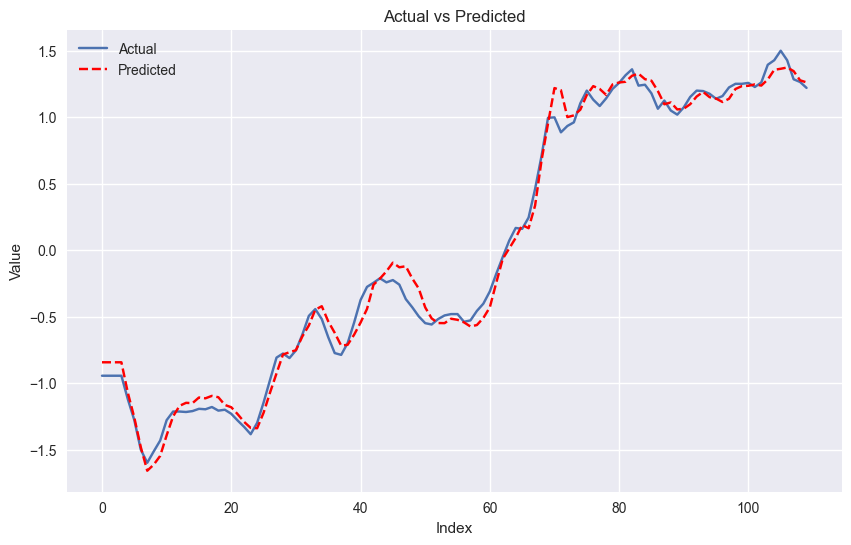

In [48]:
def result(data):
    df = data.copy()
    index = int(len(df)*0.8)

    data_train = df[:index]
    data_test = df[index:]

    X_train, y_train = data_train[['Open', 'High', 'Low', 'Close']], data_train[['Change']]
    X_test, y_test = data_test[['Open', 'High', 'Low', 'Close']], data_test[['Change']]

    data_train_scale = process_pipeline.fit_transform(X_train, y_train)
    data_test_scale =  process_pipeline.fit_transform(X_test, y_test)

    X_train, y_train = data_train_scale[:,0:3], data_train_scale[:,-1]
    X_test, y_test = data_test_scale [:,0:3], data_test_scale[:,-1]

    X_train_tensor = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    input_shape = (X_train_tensor.shape[1], X_train_tensor.shape[2])
    lstm_regressor = LSTMRegressor(input_shape)

    # Compile the model
    lstm_regressor.compile_model()

    # Train the model
    history = lstm_regressor.train(X_train, y_train)

    # Predict using the trained model
    predictions = lstm_regressor.predict(X_test)
    
    return y_test, predictions, index
y_test, predictions, index = result(data['vic'])
measure_metric(y_test, predictions)
plot_result(y_test,predictions)

# 6. Conclusion:

* In general, the LSTM model operates using a powerful algorithm, thereby allowing other models to also demonstrate good scores if not affected by pseudo-cyclic factors influencing the data.
* Furthermore, time series data handling techniques are also crucial; avoiding such factors can significantly enhance the model's performance.
* However, there are still limitations regarding the impact of economic news, so the model has not been fully optimized yet.